In [32]:
import numpy as np 
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import cv2

(104, 64, 3)


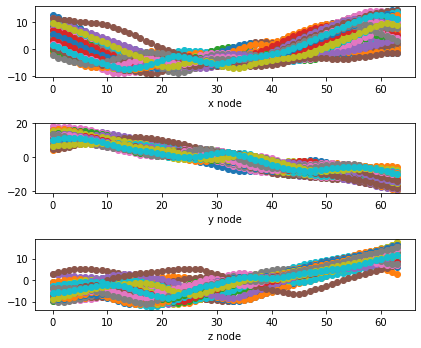

In [33]:
files = (glob.glob(".\\scaling\\vmtk64a\\*.vtk"))

#########################################
#    vmtkで計算したcurv, torsを使う      #
#       0.5mmまでresamplingした         # 
#########################################
# files = (glob.glob(".\\scaling\\resamp_attr_ascii\\vmtkgeometry\\*.vtk"))


r = []
pts = []
PTN = []
curvs = []
torss = []
abscs = [] 
for i in range(len(files)): 
    pt, Curv, Tors, Radius, Abscissas, ptns = GetMyVtk(files[i])
    if len(pt) != 64:
        print (len(pt), files[i])
        continue
    centroid = np.array([np.mean(pt[:,0]),np.mean(pt[:,1]),np.mean(pt[:,2])])
    pt = pt-centroid
    pts.append(pt)
    r.append(Radius)
    PTN.append(ptns)
    curvs.append(Curv)
    torss.append(Tors)
    abscs.append(Abscissas)
pts = np.array(pts)
r = np.array(r)
PTN = np.array(PTN)
curvs=np.array(curvs)
torss = np.array(torss)
abscs= np.array(abscs)

fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_xlabel("x node")
ax2.set_xlabel("y node")
ax3.set_xlabel("z node")
plt.tight_layout()
for i in range(100):
    ax1.scatter(range(len(pts[i])), pts[i,:,0])
    ax2.scatter(range(len(pts[i])), pts[i,:,1])
    ax3.scatter(range(len(pts[i])), pts[i,:,2])
plt.savefig("experiment_note/img/og_coord.png")

print(pts.shape)

# pre-process (cut the rear region)

In [34]:
# 切除最后两个点
pts_post = pts[:, :-5, :]
# pts_post = pts[:, 2:, :]
# vessel_87 = pts_post[87]
# vessel_87_cut = vessel_87[:-5]
# vessel_87_extended = np.concatenate((vessel_87_cut, np.full((5, 3), vessel_87_cut[-1])), axis=0)
# pts_post[87] = vessel_87_extended


# 打印新矩阵的形状
print(pts_post.shape)

(104, 59, 3)


In [53]:
import numpy as np

# oringinal matrix
original_matrix = pts_post

# extend length (how many times of the length of each 2 points)
extension_distance = 12

# obtain 1st and 2nd points' tangent
tangent1 = original_matrix[:, 1, :] - original_matrix[:, 0, :]
# set the length of each 2 points as a unit
tangent1 /= np.linalg.norm(tangent1, axis=-1, keepdims=True)
# calculate new coordinate
extended_points1 = original_matrix[:, 0, :] - extension_distance * tangent1

# obtain 63 an 64th points tangent
tangent2 = original_matrix[:, -1, :] - original_matrix[:, -2, :]
# set the length of each 2 points as a unit
tangent2 /= np.linalg.norm(tangent2, axis=-1, keepdims=True)
# # calculate new coordinate

extended_points2 = original_matrix[:, -1, :] + extension_distance * tangent2

# add new coordinate into the original matrix
extended_matrix = np.concatenate((original_matrix[:, :1, :], extended_points1[:, np.newaxis, :], original_matrix[:, 1:-1, :], extended_points2[:, np.newaxis, :], original_matrix[:, -1:, :]), axis=1)

# Swap the positions of the first and second points
point0 = extended_matrix[:, 0, :].copy()
point1 = extended_matrix[:, 1, :].copy()
extended_matrix[:, 0, :] = point1
extended_matrix[:, 1, :] = point0

# Swap the positions of the last two points
pointlast = extended_matrix[:, -1, :].copy()
pointlast2 = extended_matrix[:, -2, :].copy()
extended_matrix[:, -1, :] = pointlast2
extended_matrix[:, -2, :] = pointlast

# print(extended_matrix[20, 0:2, :])
print(extended_matrix.shape)


(104, 61, 3)


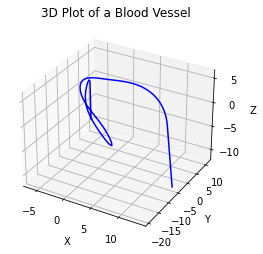

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# obtain coordinate data
vessel_data = extended_matrix[1]  # 假设为 64 个点的血管坐标数据

# create a new 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# extract  x y z
x = vessel_data[:, 0]
y = vessel_data[:, 1]
z = vessel_data[:, 2]

# draw
ax.plot(x, y, z, color='b')

# set axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# set title
ax.set_title('3D Plot of a Blood Vessel')


plt.show()


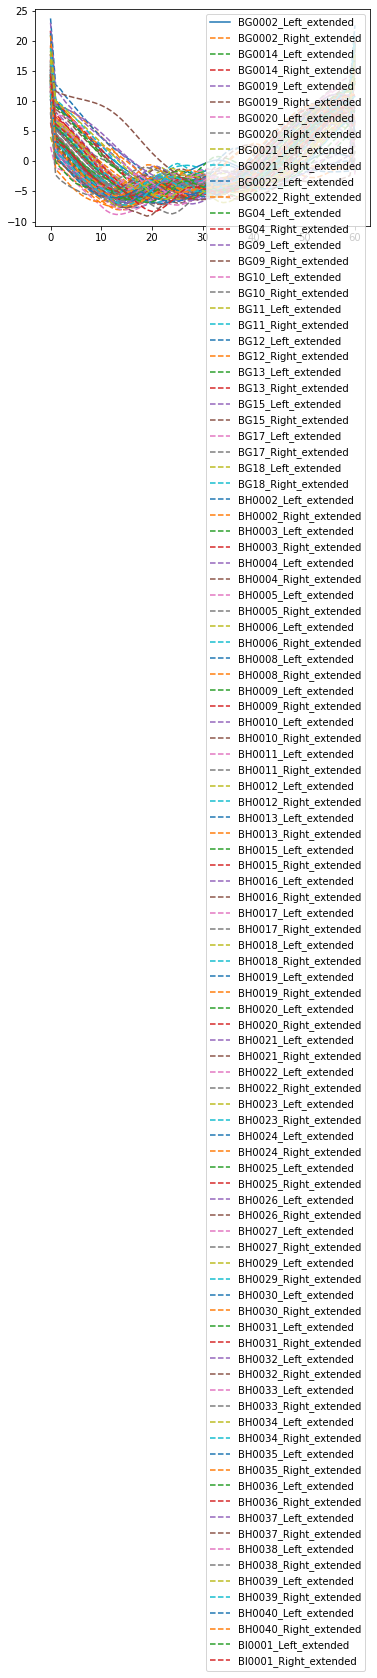

In [55]:
import os
SAVE_SYN = 1

# find path
vtk_directory = ".\\scaling\\vmtk64a\\"

# obtain all
vtk_files = [file for file in os.listdir(vtk_directory) if file.endswith(".vtk")]

namelist = [file[:-11] + "extended" for file in vtk_files]

for i in range(len(extended_matrix)):
    
    x = extended_matrix[i][:, 0]
    y = extended_matrix[i][:, 1]
    z = extended_matrix[i][:, 2]

    coords = np.column_stack((x, y, z))
    # print(coords.shape) # 64*3

    if i == 0:
        plt.plot(coords[:,0],linestyle="-", label = namelist[i])
    else:
        plt.plot(coords[:,0],linestyle="--", label = namelist[i])
    plt.legend()

    scalarAttribute = [['MaximumInscribedSphereRadius', 'float', np.mean(r, axis=1)]]

    if SAVE_SYN == 1:
        makeVtkFile(savePath="C:\\Users\\Carlos\\Desktop\\Chensan\\0322Latest\\extended_centerline\\{}.vtk".format(namelist[i]),
                    coords=coords,
                    scalarAttributes=[],
                    fieldAttributes=[])

# 

In [38]:
# for i in range(len(extended_matrix)):
#     if namelist[i] == "BH0033_Right_extended":
#         print(i)


# # original matrix
# original_matrix = pts_post

# # extend length (how many times of the length of each 2 points)
# extension_distance = 12

# # create a copy of original matrix
# extended_matrix = np.copy(original_matrix)

# # obtain 87th points' tangent
# tangent_87 = original_matrix[86, 1, :] - original_matrix[86, 0, :]
# # set the length of each 2 points as a unit
# tangent_87 /= np.linalg.norm(tangent_87)
# # calculate new coordinate
# extended_points_87 = original_matrix[86, 0, :] - extension_distance * tangent_87

# # add new coordinate into the extended matrix
# extended_matrix[86, 1] = extended_points_87

# print(extended_matrix.shape)

